In [1]:
from PIL import Image
from matplotlib import pyplot as plt
# %matplotlib notebook
import seaborn as sns
import os
import sys
sys.path.append("..")
sys.path.append("../src")

import numpy as np
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import GlobalAvgPool2D
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
import tensorflow as tf
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler

import utils
# import shell
import shell_v2 as shell

%matplotlib inline


In [10]:
# dataset_directory = "data/people"
dataset_directory = "../data/STL10/images"
# dataset_directory = "data/fruits"

In [11]:
# shell_family = shell.ShellFamily("resnet50")
shell_family = shell.ShellFamily()
shell_family.create_preprocessor("resnet50")
# shell_family.load("test.pkl")

In [12]:
def get_class_folders_from_main_directory(directory):
    sub_folders = next(os.walk(directory))[1]
    classes = sub_folders.copy()
    for i in range(len(sub_folders)):
        sub_folders[i] = os.path.join(directory, sub_folders[i])
    return sorted(sub_folders), classes

def extract_classes_sub_folder(sub_folders):
    all_image_filepaths = np.array([])
    class_array = np.array([])
    for i in range(len(sub_folders)):
        image_files = os.listdir(sub_folders[i])
        image_filepaths = list(map(lambda x : os.path.join(sub_folders[i], x), image_files))
        new_image_filepaths = []
        for j in image_filepaths:
            try:
                Image.open(j)
                new_image_filepaths.append(j)
            except:
                continue
        all_image_filepaths = np.append(all_image_filepaths, new_image_filepaths)
        class_array = np.append(class_array, [i] * len(new_image_filepaths))
#         all_image_filepaths = np.append(all_image_filepaths, image_filepaths)
#         class_array = np.append(class_array, [i] * len(image_filepaths))
    return all_image_filepaths, class_array.astype(np.int32)

In [13]:
class ImageGenerator():
    def __init__(self, filepath_array, class_array, batch_size, target_size):
        self.filepath_array = filepath_array
        self.class_array = class_array
        self.batch_size = batch_size
        self.target_size = target_size
        self.steps = len(self.class_array) // self.batch_size
        self.index = 0
        print("Found {} images with {} classes!".format(self.__len__(), len(np.unique(self.class_array))))
    
    def __iter__(self):
        return self
    
    def __len__(self):
        assert(len(self.class_array) == len(self.filepath_array))
        return len(self.class_array)
    
    def __next__(self):
        if self.index == self.__len__():
            raise StopIteration
        elif self.index + self.batch_size >= self.__len__():
            batch_filepaths = self.filepath_array[self.index : self.__len__()]
            batch_images = np.array([np.asarray(Image.open(i).convert("RGB").resize(self.target_size))[..., :3] for i in batch_filepaths]).astype(np.float32)
            batch_images = preprocess_input(batch_images)
            batch_classes = self.class_array[self.index : self.__len__()]
            self.index = self.__len__()
            return (batch_images, batch_filepaths, batch_classes)
        else:
            batch_filepaths = self.filepath_array[self.index : self.index + self.batch_size]
            batch_images = np.array([np.asarray(Image.open(i).convert("RGB").resize(self.target_size))[..., :3] for i in batch_filepaths]).astype(np.float32)
            batch_images = preprocess_input(batch_images)
            batch_classes = self.class_array[self.index : self.index + self.batch_size]
            self.index += self.batch_size
            return (batch_images, batch_filepaths, batch_classes)

In [14]:
def extract_layers(main_model, starting_layer_ix, ending_layer_ix):
    intermediate_model = Model(inputs=main_model.input, outputs=main_model.get_layer(index=ending_layer_ix).output)
    avg_pool = GlobalAvgPool2D()(intermediate_model.layers[-1].output)
    new_model = Model(inputs=intermediate_model.input, outputs=[avg_pool])
    return new_model

In [15]:
sub_folders, classes = get_class_folders_from_main_directory(dataset_directory)
filepath_array, class_array = extract_classes_sub_folder(sub_folders)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(filepath_array,
                                                    class_array,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    shuffle=True,
                                                    stratify=class_array)

In [17]:
train_image_generator = ImageGenerator(X_train, y_train, 2048, (224, 224))
test_image_generator = ImageGenerator(X_test, y_test, 1, (224, 224))

Found 4000 images with 10 classes!
Found 1000 images with 10 classes!


In [18]:
shell_family.fit(train_image_generator, classes, "../models/test.pkl")

In [19]:
y_predict = []
for processed_image_array, _, groundtruth in test_image_generator:
    sample_features = shell_family.preprocessor.predict(processed_image_array)
    class_index, class_name, score, full_results = shell_family.score(sample_features, 0.5, with_update=False, return_full_results=True)
    y_predict.append(class_index)
    print("predicted: {}, groundtruth: {}".format(class_name, shell_family.mapping[groundtruth[0]]))


predicted: bird, groundtruth: truck
predicted: dog, groundtruth: horse
predicted: dog, groundtruth: car
predicted: dog, groundtruth: dog
predicted: cat, groundtruth: cat
predicted: bird, groundtruth: bird
predicted: monkey, groundtruth: monkey
predicted: airplane, groundtruth: airplane
predicted: cat, groundtruth: cat
predicted: cat, groundtruth: cat
predicted: deer, groundtruth: deer
predicted: bird, groundtruth: bird
predicted: airplane, groundtruth: airplane
predicted: car, groundtruth: car
predicted: ship, groundtruth: ship
predicted: airplane, groundtruth: airplane
predicted: dog, groundtruth: dog
predicted: cat, groundtruth: airplane
predicted: dog, groundtruth: car
predicted: deer, groundtruth: horse
predicted: horse, groundtruth: horse
predicted: dog, groundtruth: horse
predicted: cat, groundtruth: ship
predicted: truck, groundtruth: truck
predicted: dog, groundtruth: dog
predicted: dog, groundtruth: dog
predicted: ship, groundtruth: ship
predicted: ship, groundtruth: ship
pred

predicted: bird, groundtruth: bird
predicted: monkey, groundtruth: monkey
predicted: dog, groundtruth: car
predicted: bird, groundtruth: bird
predicted: cat, groundtruth: cat
predicted: bird, groundtruth: bird
predicted: dog, groundtruth: dog
predicted: bird, groundtruth: bird
predicted: deer, groundtruth: deer
predicted: bird, groundtruth: bird
predicted: bird, groundtruth: bird
predicted: ship, groundtruth: ship
predicted: cat, groundtruth: cat
predicted: dog, groundtruth: truck
predicted: monkey, groundtruth: cat
predicted: dog, groundtruth: dog
predicted: cat, groundtruth: cat
predicted: ship, groundtruth: ship
predicted: monkey, groundtruth: monkey
predicted: deer, groundtruth: deer
predicted: car, groundtruth: car
predicted: dog, groundtruth: dog
predicted: bird, groundtruth: bird
predicted: ship, groundtruth: ship
predicted: car, groundtruth: car
predicted: monkey, groundtruth: monkey
predicted: dog, groundtruth: cat
predicted: bird, groundtruth: truck
predicted: monkey, groundt

predicted: ship, groundtruth: ship
predicted: airplane, groundtruth: airplane
predicted: bird, groundtruth: bird
predicted: horse, groundtruth: horse
predicted: monkey, groundtruth: monkey
predicted: airplane, groundtruth: airplane
predicted: dog, groundtruth: dog
predicted: airplane, groundtruth: airplane
predicted: dog, groundtruth: deer
predicted: airplane, groundtruth: airplane
predicted: bird, groundtruth: bird
predicted: airplane, groundtruth: airplane
predicted: deer, groundtruth: deer
predicted: bird, groundtruth: bird
predicted: dog, groundtruth: horse
predicted: dog, groundtruth: dog
predicted: airplane, groundtruth: airplane
predicted: truck, groundtruth: truck
predicted: airplane, groundtruth: airplane
predicted: cat, groundtruth: cat
predicted: monkey, groundtruth: cat
predicted: horse, groundtruth: horse
predicted: cat, groundtruth: cat
predicted: ship, groundtruth: ship
predicted: monkey, groundtruth: monkey
predicted: truck, groundtruth: truck
predicted: bird, groundtru

predicted: dog, groundtruth: dog
predicted: deer, groundtruth: deer
predicted: dog, groundtruth: deer
predicted: dog, groundtruth: truck
predicted: dog, groundtruth: truck
predicted: airplane, groundtruth: airplane
predicted: ship, groundtruth: ship
predicted: deer, groundtruth: deer
predicted: bird, groundtruth: bird
predicted: dog, groundtruth: car
predicted: truck, groundtruth: truck
predicted: airplane, groundtruth: airplane
predicted: cat, groundtruth: cat
predicted: cat, groundtruth: cat
predicted: dog, groundtruth: car
predicted: bird, groundtruth: ship
predicted: dog, groundtruth: dog
predicted: bird, groundtruth: bird
predicted: horse, groundtruth: horse
predicted: deer, groundtruth: deer
predicted: bird, groundtruth: airplane
predicted: car, groundtruth: car
predicted: bird, groundtruth: bird
predicted: horse, groundtruth: horse
predicted: truck, groundtruth: truck
predicted: bird, groundtruth: bird
predicted: dog, groundtruth: car
predicted: cat, groundtruth: cat
predicted: 

predicted: monkey, groundtruth: monkey
predicted: cat, groundtruth: cat
predicted: horse, groundtruth: horse
predicted: cat, groundtruth: cat
predicted: cat, groundtruth: cat
predicted: ship, groundtruth: ship
predicted: dog, groundtruth: dog
predicted: dog, groundtruth: car
predicted: cat, groundtruth: cat
predicted: airplane, groundtruth: airplane
predicted: monkey, groundtruth: monkey
predicted: truck, groundtruth: truck
predicted: monkey, groundtruth: monkey
predicted: airplane, groundtruth: airplane
predicted: horse, groundtruth: horse
predicted: dog, groundtruth: car
predicted: bird, groundtruth: ship
predicted: car, groundtruth: car
predicted: ship, groundtruth: ship
predicted: dog, groundtruth: car
predicted: ship, groundtruth: ship
predicted: ship, groundtruth: ship
predicted: cat, groundtruth: car
predicted: car, groundtruth: car
predicted: cat, groundtruth: cat
predicted: truck, groundtruth: truck
predicted: cat, groundtruth: cat
predicted: dog, groundtruth: deer
predicted: 

In [114]:
full_results

OrderedDict([('airplane', array([-6.592903], dtype=float32)),
             ('bird', array([-5.941028], dtype=float32)),
             ('car', array([-8.171644], dtype=float32)),
             ('cat', array([-5.2369847], dtype=float32)),
             ('deer', array([-4.501968], dtype=float32)),
             ('dog', array([-1.7619989], dtype=float32)),
             ('horse', array([0.35825187], dtype=float32)),
             ('monkey', array([-4.5457], dtype=float32)),
             ('ship', array([-6.2599726], dtype=float32)),
             ('truck', array([-5.656966], dtype=float32))])

In [20]:
y_predict = np.array(y_predict)

In [21]:
classification_report(y_test, y_predict, output_dict=False)

'              precision    recall  f1-score   support\n\n           0       0.94      0.95      0.95       100\n           1       0.92      0.98      0.95       100\n           2       1.00      0.59      0.74       100\n           3       0.80      0.90      0.85       100\n           4       0.95      0.57      0.71       100\n           5       0.49      0.98      0.66       100\n           6       0.91      0.79      0.84       100\n           7       0.96      0.97      0.97       100\n           8       0.99      0.87      0.93       100\n           9       0.93      0.81      0.87       100\n\n    accuracy                           0.84      1000\n   macro avg       0.89      0.84      0.85      1000\nweighted avg       0.89      0.84      0.85      1000\n'

Classification Report

              precision    recall  f1-score   support

           0       0.94      0.95      0.95       100
           1       0.92      0.98      0.95       100
           2       1.00      0.59      0.74       100
           3       0.80      0.90      0.85       100
           4       0.95      0.57      0.71       100
           5       0.49      0.98      0.66       100
           6       0.91      0.79      0.84       100
           7       0.96      0.97      0.97       100
           8       0.99      0.87      0.93       100
           9       0.93      0.81      0.87       100

    accuracy                           0.84      1000
   macro avg       0.89      0.84      0.85      1000
weighted avg       0.89      0.84      0.85      1000


Confusion Matrix



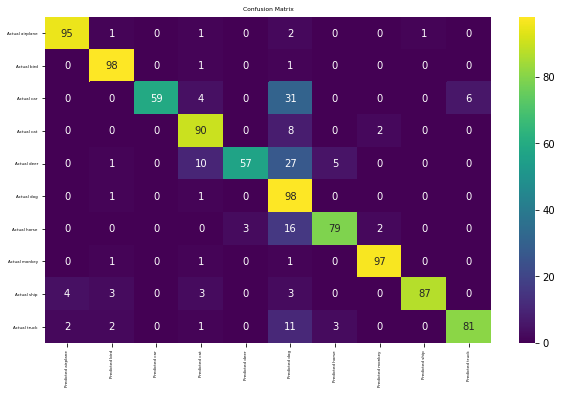

In [22]:
xtick_labels = ["Predicted {}".format(class_name) for class_name in shell_family.mapping]
ytick_labels = ["Actual {}".format(class_name) for class_name in shell_family.mapping]
print("Classification Report\n")
print(classification_report(y_test, y_predict))
print("")
print("Confusion Matrix\n")
plt.figure(figsize=(10,6))
sns.heatmap(confusion_matrix(y_test, y_predict), cmap="viridis", annot=True, fmt="d", xticklabels=xtick_labels, yticklabels=ytick_labels)
plt.title("Confusion Matrix", fontsize=6)
plt.tick_params(axis='both', which='major', labelsize=4)
plt.show()

2D PCA

Text(0.5, 1.0, 'PCA shell mean')

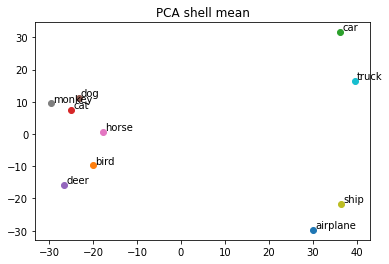

In [123]:
mean_array = []
noise_array = []
for shell in shell_family.classifiers:
    mean_array.append(shell_family.classifiers[shell].shell_mean[0])
scaler = StandardScaler()
scaled_mean = scaler.fit_transform(mean_array)
pca = PCA(n_components=2, random_state=42)
transformed = pca.fit_transform(scaled_mean)
for i in range(len(transformed)):
    plt.scatter(transformed[i, 0], transformed[i, 1])
    plt.text(transformed[i, 0] + 0.5, transformed[i, 1] + 0.5, shell_family.mapping[i])
plt.title("PCA shell mean")

3D PCA

In [56]:
mean_array = []
for shell in shell_family.classifiers:
    mean_array.append(shell_family.classifiers[shell].shell_mean[0])
scaler = StandardScaler()
scaled_mean = scaler.fit_transform(mean_array)
pca = PCA(n_components=3, random_state=42)
transformed = pca.fit_transform(scaled_mean)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for i in range(len(transformed)):
    ax.scatter(transformed[i, 0], transformed[i, 1], transformed[i, 2])
    ax.text(transformed[i, 0] + 0.5, transformed[i, 1] + 0.5, transformed[i, 2], shell_family.mapping[i])
plt.title("PCA shell mean")


<IPython.core.display.Javascript object>

Text(0.5, 0.92, 'PCA shell mean')